# AutoFarm - Time Series of Temperature and Humidity

In my other notebook, we did some really great [analysis and data wrangling on the AutoFarm dataset on soil moisture](https://jackmead515.github.io/notebooks/auto_farm_soil_2.html). We are going to pickup that dataset and do some different analysis. I wanted to try a different type of analysis: time series. Just like the regression models, there is a level of increasing complexity that can be used for prediction. One of the simpliest models being ARIMA (AutoRegressive Integrated Moving Average) and the more complex being neural network approaches like the LSTM (Long Short Term Memory).

In this notebook, I'm going to explore and compare different time series models to predict the temperature and humidity of the AutoFarm dataset. So much has been written about these models and I will provide links to the resources I used to learn about them. No sense and rewriting what has already been written by more capable authors.

In [1]:
import pandas as pd

df = pd.read_parquet('auto_farm_metrics.parquet')

df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['watering_start'] = pd.to_datetime(df['watering'].apply(lambda x: x.split(' - ')[0]))
df['watering_end'] = pd.to_datetime(df['watering'].apply(lambda x: x.split(' - ')[1]))

df = df.drop(columns=['watering'])

df

,timestamp,dht11_air_temp,dht11_air_humid,ds18b20_air_temp_0,ds18b20_air_temp_1,soil_moisture_0,soil_moisture_1,soil_moisture_2,soil_moisture_3,avg_soil_moisture,brightness,watering_start,watering_end
0,2020-10-10 07:00:00,32.000000,63.754826,27.704363,27.293797,417.498069,463.480695,481.974903,326.843629,422.449324,0.000000,2020-10-10 06:57:00,2020-10-11 23:53:00
1,2020-10-10 07:10:00,32.000000,63.632296,27.633689,27.578280,434.618677,475.237354,453.719844,322.889105,421.616245,0.000000,2020-10-10 06:57:00,2020-10-11 23:53:00
2,2020-10-10 07:20:00,32.000000,63.215116,27.556795,27.496446,438.647287,475.158915,450.346899,322.496124,421.662306,0.000000,2020-10-10 06:57:00,2020-10-11 23:53:00
3,2020-10-10 07:30:00,32.000000,63.022814,27.440209,27.397051,441.794677,475.442966,451.977186,323.192015,423.101711,0.000000,2020-10-10 06:57:00,2020-10-11 23:53:00
4,2020-10-10 07:40:00,32.000000,63.118447,27.238981,27.232012,445.568932,476.543689,454.366990,324.236893,425.179126,0.000000,2020-10-10 06:57:00,2020-10-11 23:53:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4015,2020-11-08 01:10:00,32.274662,67.290135,27.719818,27.958708,487.388781,463.040619,412.077369,322.647969,421.288685,124.100862,2020-11-04 20:34:00,2020-11-08 03:33:00
4016,2020-11-08 01:20:00,32.013436,67.911708,27.760113,28.013246,488.570058,464.155470,412.541267,322.827255,422.023512,123.418997,2020-11-04 20:34:00,2020-11-08 03:33:00
4017,2020-11-08 01:30:00,32.000000,68.000000,27.834587,28.057213,489.788462,465.150000,413.225000,323.507692,422.917788,122.864865,2020-11-04 20:34:00,2020-11-08 03:33:00
4018,2020-11-08 01:40:00,32.000000,68.000000,27.856563,28.067134,490.801942,465.866019,413.541748,323.900971,423.527670,122.810977,2020-11-04 20:34:00,2020-11-08 03:33:00


To start, let's begin with a basic train test split. But in time series, spliting the data randomly wouldn't make any sense. Since we are predicting into the future, we need each split to be a contiguous block of time. Simple for us, since we can just sort by time and split the data that way.

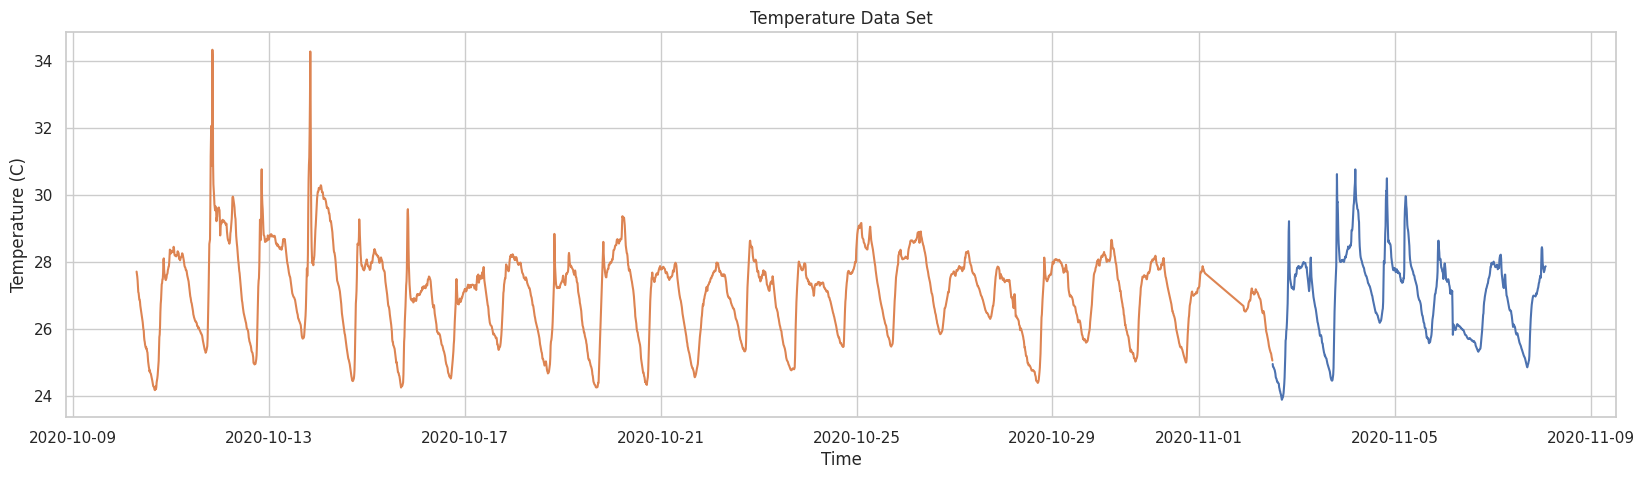

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

df = df.sort_values('timestamp')

train_indicies = len(df) * 0.8
df['train_set'] = df.index < train_indicies
df['test_set'] = df.index >= train_indicies

plt.figure(figsize=(20, 5))
sns.lineplot(data=df, x='timestamp', y='ds18b20_air_temp_0', hue='train_set')
plt.title('Temperature Data Set')
plt.xlabel('Time')
plt.ylabel('Temperature (C)')
plt.legend([],[], frameon=False)
plt.show()

## Arima Model

To start, as a baseline, the Arima model will be used. Some great resources that I used to learn about the Arima model are:

[ARIMA Model – Complete Guide to Time Series Forecasting in Python](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)
[statsmodels.tsa.arima.model.ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html)
[What is an ARIMA Model?](https://towardsdatascience.com/what-is-an-arima-model-9e200f06f9eb)

Even though it's quite simple, it can be intimidating at first. There are many parameters that can be tuned and knowing what each ones does takes some time to learn about.

In [4]:
import pmdarima as pm

train = df[df['train_set']]['ds18b20_air_temp_0']
test = df[df['test_set']]['ds18b20_air_temp_0']

model = pm.auto_arima(
        train,
        start_p=1,
        start_q=1,
        start_P=1,
        start_Q=1,
        max_p=5,
        max_q=5,
        max_P=5,
        max_Q=5,
        stepwise=True,
        suppress_warnings=True,
        D=10,
        max_D=10,
        error_action='ignore',
        seasonal=True,
        m=7,
        maxiter=20
)

forecast = model.predict(n_periods=len(test))

plt.figure(figsize=(20, 5))
sns.lineplot(data=df, x='timestamp', y='ds18b20_air_temp_0', hue='train_set')
plt.plot(df[df['test_set']]['timestamp'], forecast, label='Forecast')
plt.title('Temperature Data Set')
plt.xlabel('Time')
plt.ylabel('Temperature (C)')
plt.show()

KeyboardInterrupt: 